In [1]:
%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

from scipy import stats
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Возьмем выборку нефть-brent-2010-2019.csv

data = pd.read_excel('нефть-brent 2010-2019.xlsx', index_col=[0], parse_dates=[0])
data.head()

,Value
Datetime,
2019-09-01,58.84
2019-08-30,59.19
2019-08-29,60.37
2019-08-28,59.84
2019-08-27,59.59


In [4]:
data.describe()  #statistic

,Value
count,2667.000000
mean,81.533547
std,26.349469
min,27.850000
25%,56.840000
50%,77.710000
75%,108.190000
max,126.900000


count - количество записей, mean - среднее значение, std - стандартное отклонение, указывающее на разброс данных по среднему значению, min - минимальное значение в наборе, max - максимальное значение в наборе вместе с диапазоном процентов. Процентили могут помочь нам понять распределение вероятностей наших данных.

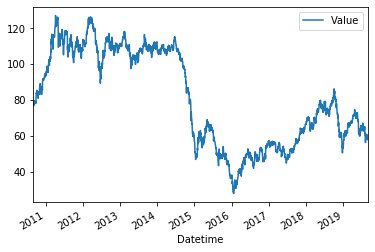

In [5]:
data.plot()

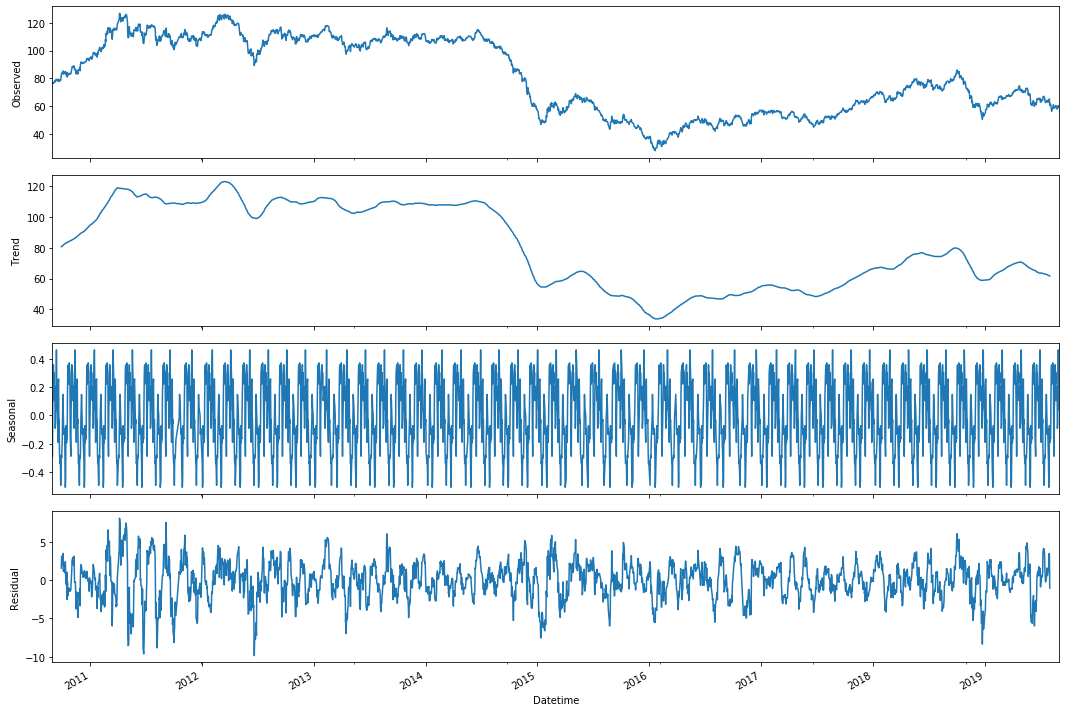

<Figure size 1080x720 with 0 Axes>

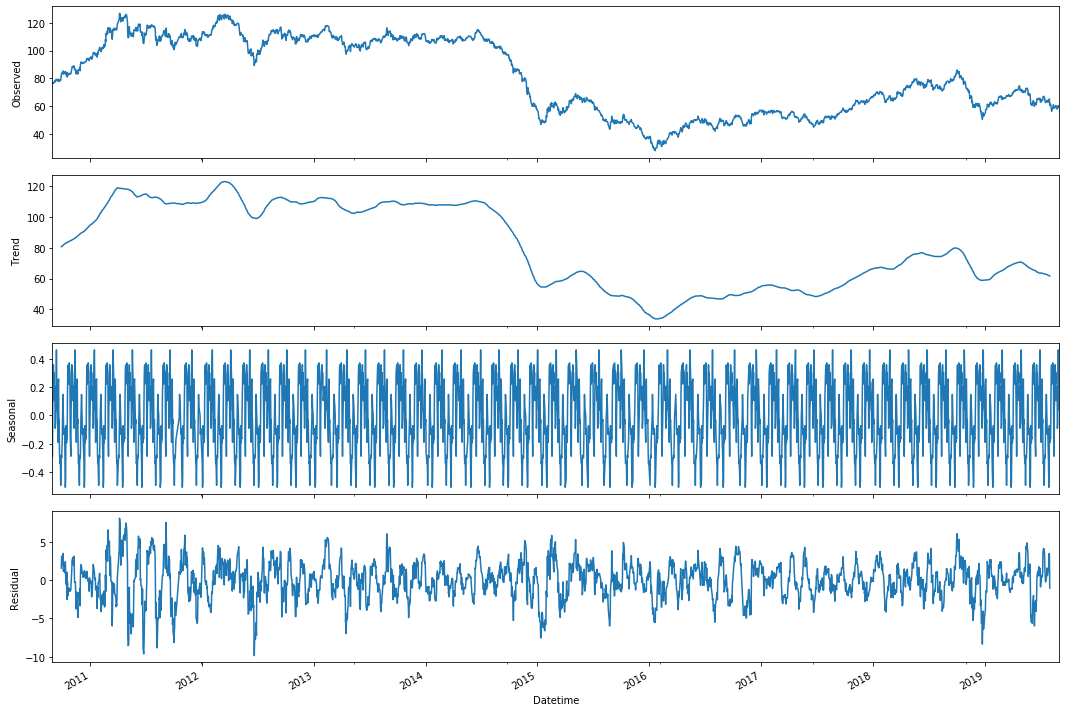

In [7]:
#Ряд не стационарен из за тренда
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.Value, freq=52).plot()

In [8]:
#ряд нестационарен из за сезонности и тренда.
data_m = data.resample('MS').mean()
data_m.tail()

,Value
Datetime,
2019-05-01,69.966667
2019-06-01,62.980400
2019-07-01,64.292963
2019-08-01,59.263077
2019-09-01,58.840000


ресемплинг по месяцам
    Arima

In [9]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [10]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1267.823602907197
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1037.0995022832255
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:859.8637631111692
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:756.9219887219627
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:860.1066570687592
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:848.6112628967846
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:766.1328929711766
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:758.8518088652073
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1116.9895536619063
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:906.040421225106
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:749.1660630222011
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:661.1103133018248
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:758.8935792036697
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:740.9202995130457
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:675.8390885381303
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:662.6222024663389
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:663.7534387012971
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:585.1550115140361
ARIMA(0, 

Вывод нашего кода предполагает, что SARIMAX(1, 1, 1)x(1, 1, 1, 12)дает самое низкое AICзначение 518.93. Поэтому мы должны считать это оптимальным вариантом из всех рассмотренных нами моделей.

Начнем с добавления оптимальных значений параметров в новую SARIMAX модель:

In [12]:
mod = sm.tsa.statespace.SARIMAX(data_m,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1560      0.220      0.708      0.479      -0.276       0.588
ma.L1          0.2818      0.234      1.204      0.229      -0.177       0.741
ar.S.L12       0.0016      0.008      0.201      0.841      -0.014       0.017
ma.S.L12      -0.8099      0.175     -4.628      0.000      -1.153      -0.467
sigma2        26.8517      5.118      5.247      0.000      16.821      36.883


summaryАтрибут , который является результатом вывода SARIMAXвозвращает значительное количество информации, но мы сосредоточим наше внимание на таблицу коэффициентов. В coefстолбце отображается вес (т.е. важность) каждый признак и как каждый из которых влияют на временные ряды. P>|z|Колонна сообщает нам о значении каждого веса признака. Здесь каждый вес имеет значение p ниже или близко к нему 0.5, поэтому разумно сохранить их все в нашей модели.

При подборе сезонных моделей ARIMA (и любых других моделей по этому вопросу) важно проводить диагностику модели, чтобы убедиться, что ни одно из допущений, сделанных моделью, не было нарушено. plot_diagnosticsОбъект позволяет быстро создавать модели диагностики и исследования для любого необычного поведения.

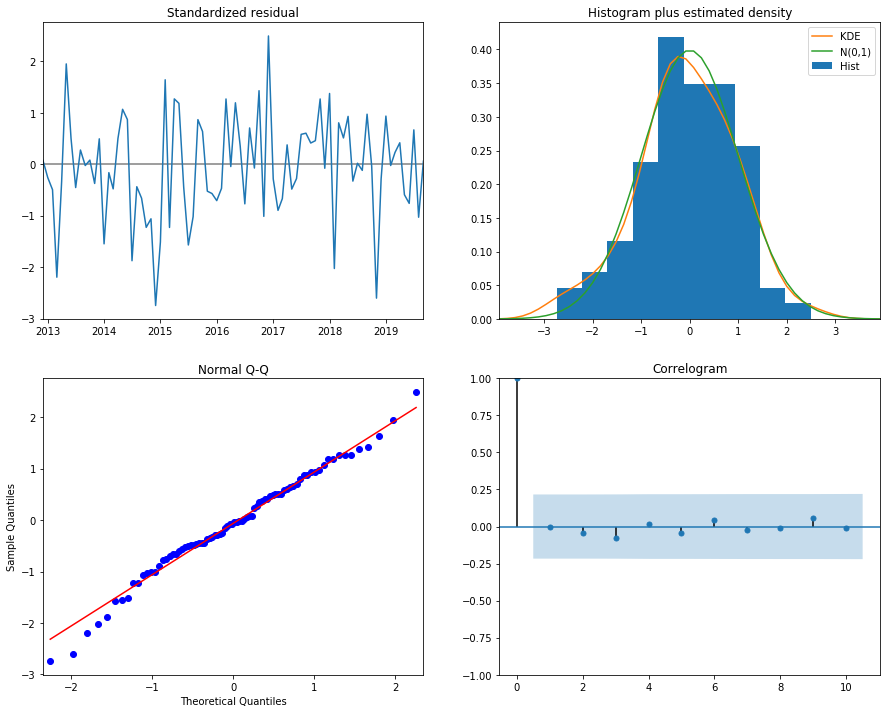

In [13]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()